In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2 
from pycocotools.coco import COCO
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
tf.__version__


'2.8.2'

In [ ]:
# !wget http://images.cocodataset.org/zips/val2014.zip
# !wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
# !unzip /content/val2014.zip
# !unzip annotations_trainval2014.zip
# !rm val2014.zip
# !rm annotations_trainval2014.zip

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# dataDir='./COCOdataset2017'
# dataType='val'
annFile="./annotations/instances_val2014.json"

# Initialize the COCO api for instance annotations
coco=COCO(annFile)


loading annotations into memory...
Done (t=15.26s)
creating index...
index created!


In [ ]:
class Reflection_here(keras.layers.Layer):
  def __init__(self, padding=(1, 1), **kwargs):
    super(Reflection_here,self).__init__(**kwargs)
    self.padding = tuple(padding)

  def get_output_shape_for(self, s):
    """ If you are using "channels_last" configuration"""
    return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

  def call(self, x, mask=None):
    w_pad,h_pad = self.padding
    return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')


In [ ]:
def down_block_model(x,feature,kernel_size=4,stride=2,padding=(1,1)):
  init=tf.random_normal_initializer(0., 0.02)
  x=Reflection_here(padding=padding)(x)
  x=keras.layers.Conv2D(feature,kernel_size,strides=stride,padding="valid",use_bias=False,kernel_initializer=init)(x)
  x=keras.layers.BatchNormalization()(x)
  x=keras.layers.LeakyReLU(alpha=0.1)(x)
  return x


In [ ]:
def down_block_model_gen(x,feature,kernel_size=4,stride=2,padding=(1,1)):
  init=tf.random_normal_initializer(0., 0.02)
  x=Reflection_here(padding=padding)(x)
  x=keras.layers.Conv2D(feature,kernel_size,strides=stride,padding="valid",use_bias=False,kernel_initializer=init)(x)
  x=keras.layers.BatchNormalization()(x)
  x=keras.layers.LeakyReLU(alpha=0.1)(x)
  return x

def up_block_model_gen(x,concate,feature,kernel_size=4,stride=2,dropout_rate=0.5,drop_out=False):
  init=tf.random_normal_initializer(0., 0.02)
  x=keras.layers.Conv2DTranspose(feature,kernel_size,strides=stride,padding="same",use_bias=False,kernel_initializer=init)(x)
  x=keras.layers.BatchNormalization()(x)
  if drop_out:
    x=keras.layers.Dropout(dropout_rate)(x,training=True)
  x=keras.activations.relu(x)
  x=tf.concat([x, concate], 3)
  return x

In [ ]:
def discriminator_model(features,x_input_channels,y_input_channels):
  init=tf.random_normal_initializer(0., 0.02)
  inputs_x=keras.Input(shape=(256,256,x_input_channels))
  inputs_y=keras.Input(shape=(256,256,y_input_channels))
  inputs=tf.concat([inputs_x, inputs_y], 3)
  x=Reflection_here()(inputs)
  x=keras.layers.Conv2D(features[0],4,strides=2,padding="valid",kernel_initializer=init)(x)
  x=keras.layers.LeakyReLU(alpha=0.1)(x)
  for idx,feature in enumerate(features[1:]):  
    x=down_block_model(x,feature)
  x=down_block_model(x,512,kernel_size=3,stride=1,padding=(1,1)) 
  x=Reflection_here(padding=(1,1))(x)
  outputs=keras.layers.Conv2D(1,3,1,padding="valid",kernel_initializer=init)(x)
  # outputs=keras.activations.sigmoid(x)
  final_model=keras.Model(inputs=[inputs_x,inputs_y],outputs=outputs)
  return final_model



In [ ]:
def encoder_block(inputs,features=[64,128,256,512]):
  init=tf.random_normal_initializer(0., 0.02)
  skip_connections=[]
  x=Reflection_here()(inputs)
  x=keras.layers.Conv2D(features[0],4,strides=2,padding="valid",kernel_initializer=init)(x)
  x=keras.layers.LeakyReLU(alpha=0.1)(x)
  skip_connections.append(x)
  for idx,feature in enumerate(features[1:]):  
    x=down_block_model_gen(x,feature)
    skip_connections.append(x)
  x=down_block_model_gen(x,512) 
  skip_connections.append(x)
  x=down_block_model_gen(x,512) 
  skip_connections.append(x)
  x=down_block_model_gen(x,512) 
  skip_connections.append(x)
  x=keras.layers.Conv2D(512,4,2,padding="same",kernel_initializer=init)(x)
  x=keras.activations.relu(x)
  return x , skip_connections[::-1]

In [ ]:
def decoder_block(x,output_channels,skip_connections,features=[512,512,512,512,256,128,64]):
  init= tf.random_normal_initializer(0., 0.02)
  for i,concate in enumerate(skip_connections):
    if i<=2:
      x=up_block_model_gen(x,concate,features[i],drop_out=True)
    else:
      x=up_block_model_gen(x,concate,features[i],drop_out=False)
  x=keras.layers.Conv2DTranspose(output_channels,kernel_size=4,strides=2,padding="same",kernel_initializer=init,activation='tanh')(x)
  return x

In [ ]:
def generator_model(in_channels,output_channels=3):
  inputs=keras.Input(shape=(256,256,in_channels))
  x,skip_connections=encoder_block(inputs)
  outputs=decoder_block(x,output_channels,skip_connections)
  final_model=keras.Model(inputs=inputs,outputs=outputs)
  return final_model

In [ ]:
model_discriminator=discriminator_model([64,128,256,512],x_input_channels=3,y_input_channels=3)

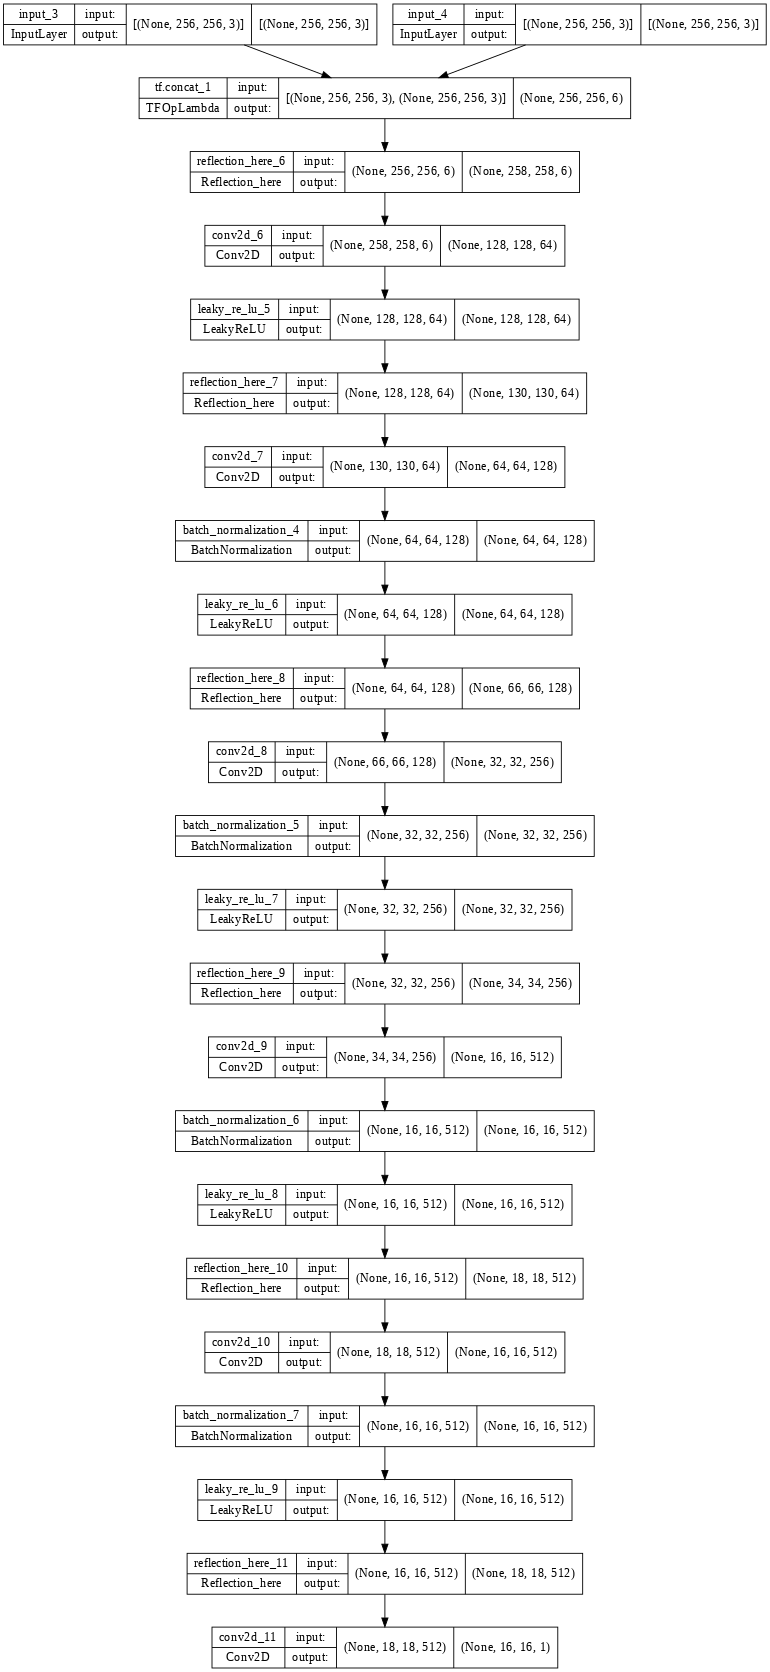

In [ ]:
tf.keras.utils.plot_model(model_discriminator, show_shapes=True, dpi=64)

In [ ]:
model_generator=generator_model(3)

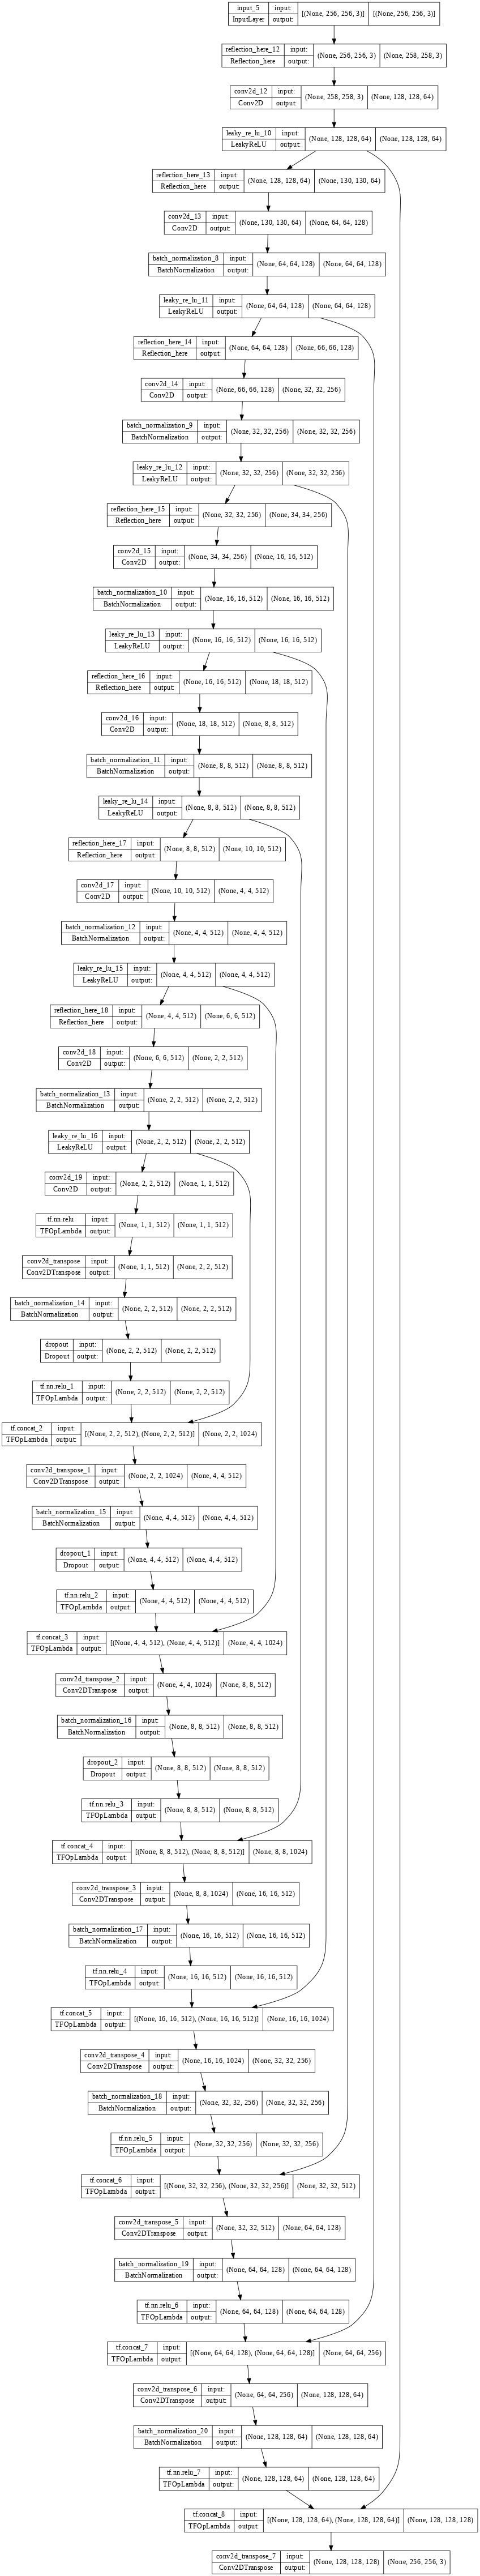

In [ ]:
tf.keras.utils.plot_model(model_generator, show_shapes=True, dpi=64)

In [ ]:
y=np.random.randint(0,255,size=(1,256,256,3))
x=np.random.randint(0,255,size=(1,256,256,3))
print(model_discriminator([y,x]).shape)
print(model_generator(x).shape)

(1, 16, 16, 1)
(1, 256, 256, 3)


In [ ]:
def preprocess_image(image_):
  image_=cv2.resize(image_,(256,256),interpolation=cv2.INTER_CUBIC)
  image_=image_/255-0.5
  # print("image max",np.amax(image_))
  return image_

def preprocess_mask(mask):
  mask=cv2.resize(mask,(256,256),interpolation=cv2.INTER_AREA)
  mask=mask/255
  # print("image max",np.amax(image_))
  return mask


In [ ]:
import os
import glob

def arrange_images(dataset_loc):
  subfolders = [ f.path for f in os.scandir(dataset_loc) if f.is_dir() ] 
  os.chdir(subfolders[0])
  data_list=[]
  for file in glob.glob("*.png"):
    mask_name=os.path.splitext(file)[0]+".json_GT.jpg"
    mask_path=subfolders[1]+"/"+mask_name
    image_path=subfolders[0]+"/"+file
    if os.path.exists(mask_path):
      data_list.append([image_path,mask_path])
  return data_list

  # for image_name in image_names:
  # print(images_names)



In [ ]:
# arrange_images("/content/gdrive/MyDrive/pix2pix_peshal")

In [ ]:
# arrange_images("/content/gdrive/MyDrive/pix2pix_peshal")

In [ ]:

# # Fetch class IDs only corresponding to the filterClasses
# catIds = coco.getCatIds(catIds=filterClasses) 
# # Get all images containing the above Category IDs
# imgIds = coco.getImgIds(catIds=catIds)

import random 

def DataGenerator(batch_size,dataset_loc):
  images_mask_list=arrange_images(dataset_loc)
  total_length=len(images_mask_list)
  print("totallength",total_length)
  total_batches=total_length//batch_size

  for i in range(total_batches):
    image_list=[]
    mask_list=[]
    start=i*batch_size
    end=start+batch_size
    if end>=total_length:
      end=total_length
    for i in range(start,end):
      index_value=random.randint(0,(total_length-1))
      image_path=images_mask_list[index_value][0]
      mask_path=images_mask_list[index_value][1]
      Image = cv2.imread(image_path)
      Image=cv2.cvtColor(Image,cv2.COLOR_BGR2RGB)
      mask = cv2.imread(mask_path)
      mask=cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
      # print("max image: ",np.amax(Image))
      # print("min image: ",np.amin(Image))
      image=preprocess_image(Image)
      mask=preprocess_mask(mask)
      image_list.append(image)
      mask_list.append(mask)
    image_here=tf.convert_to_tensor(image_list)
    # mask_here=tf.expand_dims(tf.convert_to_tensor(mask_list),axis=3)
    mask_here=tf.convert_to_tensor(mask_list)
    yield image_here,mask_here


In [ ]:
learning_rate=2e-4
batches=30
epochs=100
loss1=tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss2=tf.keras.losses.MeanAbsoluteError()
accuracy_metrics=tf.keras.metrics.BinaryAccuracy()
optimizer_discriminator=keras.optimizers.Adam(learning_rate,beta_1=0.5)
optimizer_generator=keras.optimizers.Adam(learning_rate,beta_1=0.5)
lamda_value=100

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
with tf.device('/GPU:0'):
  from tensorflow.python.ops.gradients_impl import gradients
  for epoch in range(epochs):
    for idx, (y_image,x_image) in enumerate(DataGenerator(batch_size=batches,dataset_loc="/content/pix2pix")):
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generator_output=model_generator(x_image,training=True)

        output_discriminator_real=model_discriminator([y_image,x_image],training=True)
        output_discriminator_fake=model_discriminator([generator_output,x_image],training=True)

        loss_discriminator=loss1(y_true=tf.ones_like(output_discriminator_real),y_pred=output_discriminator_real)
        loss_generator_1=loss1(y_true=tf.zeros_like(output_discriminator_fake),y_pred=output_discriminator_fake)
        lossD_=(loss_discriminator+loss_generator_1)

        loss_generator_2=loss1(y_true=tf.ones_like(output_discriminator_fake),y_pred=output_discriminator_fake)
        loss_L1=loss2(y_true=y_image,y_pred=generator_output)
        lossG_=(loss_generator_2+lamda_value*loss_L1)

      gradients_generator=gen_tape.gradient(lossG_,model_generator.trainable_variables)
      gradients_discriminator=disc_tape.gradient(lossD_,model_discriminator.trainable_variables)


      optimizer_generator.apply_gradients(zip(gradients_generator,model_generator.trainable_variables))
      optimizer_discriminator.apply_gradients(zip(gradients_discriminator,model_discriminator.trainable_variables))

      
      # if (idx+1)%100==0:
      print("discriminator loss",lossD_)
      print("generator loss",lossG_)
    # model_discriminator.save_weights('./checkpoints/discriminator/')
    # model_generator.save_weights('./checkpoints/generator/')



totallength 50
discriminator loss tf.Tensor(1.1896794, shape=(), dtype=float32)
generator loss tf.Tensor(19.333652, shape=(), dtype=float32)
totallength 50
discriminator loss tf.Tensor(1.6934705, shape=(), dtype=float32)
generator loss tf.Tensor(20.033861, shape=(), dtype=float32)
totallength 50
discriminator loss tf.Tensor(1.6970193, shape=(), dtype=float32)
generator loss tf.Tensor(19.115469, shape=(), dtype=float32)
totallength 50
discriminator loss tf.Tensor(1.335096, shape=(), dtype=float32)
generator loss tf.Tensor(19.19025, shape=(), dtype=float32)
totallength 50
discriminator loss tf.Tensor(1.2422336, shape=(), dtype=float32)
generator loss tf.Tensor(18.435488, shape=(), dtype=float32)
totallength 50
discriminator loss tf.Tensor(1.2542025, shape=(), dtype=float32)
generator loss tf.Tensor(18.511385, shape=(), dtype=float32)
totallength 50
discriminator loss tf.Tensor(1.1813409, shape=(), dtype=float32)
generator loss tf.Tensor(18.999231, shape=(), dtype=float32)
totallength 50


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# !mkdir /content/gdrive/MyDrive/models/disciminator
# !mkdir /content/gdrive/MyDrive/models/generator

In [ ]:
# model_generator.save("./models/generator")
# model_discriminator.save("./models/disciminator")